In [ ]:
import torch
import torch.nn as nn
from torch.func import jacrev, jacfwd, vmap

import numpy as np
import matplotlib.pyplot as plt # need 3.10 plus for "berlin" cmap
import matplotlib.colors as mcolors

from simulate import simulate_convergence, simulate_merge, simulate_branching, simulate_deflection, simulate_ridge
from visualise import visualise_v_quiver, visualise_v_stream
from NN_models import dfNN_for_vmap

from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

/home/kim/ice_thickness/visualise.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cmap_berlin_tensor = torch.load("configs/vis/cmap_berlin_tensor.pt")


In [ ]:
model = dfNN_for_vmap()

# parse one point
print(model(torch.tensor([1.0, 0.5]))) 

# parse two points
print(vmap(model)(torch.tensor([[1.0, 0.5], [0.5, 1.0]])))

tensor([-0.0910, -0.0147], grad_fn=<SumBackward1>)
tensor([[-0.0910, -0.0147],
        [-0.0671,  0.0388]], grad_fn=<SumBackward1>)


In [33]:
# overwrite with 20 * 20 grid
N = 20 * 20 # N should be a perfect square
N_side = int(N ** 0.5)

dims = 2

# inputs = torch.randn(N, dims)  # Random (N, 2) inputs
xy_side = torch.linspace(0, 1, N_side)
# torch meshgrid, not default but we want to index by x, y
X_mesh, Y_mesh = torch.meshgrid(xy_side, xy_side, indexing = "xy")

# Construct flat pairs of points
# now the span [0, 3]
x_test = torch.cat([X_mesh.reshape(-1, 1), Y_mesh.reshape(-1, 1)], dim = 1)
print(x_test.shape)

torch.Size([400, 2])


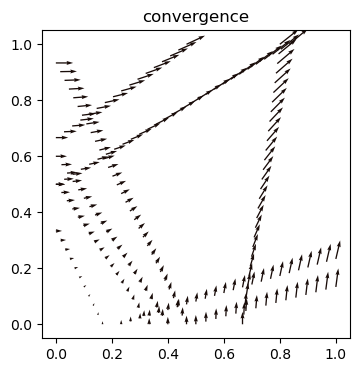

In [34]:
# float32 is default for
x_train = torch.load("data/sim_data/x_train_lines_discretised_0to1.pt", weights_only = True).float().requires_grad_()
# x_train = inputs_03
y_train = simulate_convergence(x_train).float()

visualise_v_quiver(y_train.detach(), x_train.detach(), title_string = "convergence")

In [35]:
# Convert to DataLoader for batching
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

# Initialise fresh model
model_v = dfNN_for_vmap()
model_v.train()

# Define loss function (e.g., MSE for regression)
criterion = nn.MSELoss()

# Define optimizer (e.g., Adam)
optimizer = optim.AdamW(model_v.parameters(), lr = 0.0001, weight_decay = 1e-4)
num_epochs = 300

# Initialise tensor to store losses
epoch_losses = torch.zeros(num_epochs)

print()
print("Start Training")
for epoch in range(num_epochs):

    epoch_loss = 0.0  # Accumulate batch losses

    for batch in dataloader:
        x_batch, y_batch = batch
        x_batch.requires_grad_()

        y_pred = vmap(model_v)(x_batch)

        # Compute loss: RMSE
        loss = torch.sqrt(criterion(y_pred, y_batch))
        epoch_loss += loss.item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Store the average loss for the epoch
    epoch_losses[epoch] = epoch_loss / len(dataloader)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss (RMSE): {loss.item():.4f}")


Start Training
Epoch 1/300, Training Loss (RMSE): 0.4397
Epoch 2/300, Training Loss (RMSE): 0.4615
Epoch 3/300, Training Loss (RMSE): 0.3981
Epoch 4/300, Training Loss (RMSE): 0.3544
Epoch 5/300, Training Loss (RMSE): 0.4416
Epoch 6/300, Training Loss (RMSE): 0.3136
Epoch 7/300, Training Loss (RMSE): 0.5819
Epoch 8/300, Training Loss (RMSE): 0.5303
Epoch 9/300, Training Loss (RMSE): 0.4413
Epoch 10/300, Training Loss (RMSE): 0.5813
Epoch 11/300, Training Loss (RMSE): 0.2758
Epoch 12/300, Training Loss (RMSE): 0.5373
Epoch 13/300, Training Loss (RMSE): 0.4089
Epoch 14/300, Training Loss (RMSE): 0.4428
Epoch 15/300, Training Loss (RMSE): 0.2508
Epoch 16/300, Training Loss (RMSE): 0.3650
Epoch 17/300, Training Loss (RMSE): 0.2673
Epoch 18/300, Training Loss (RMSE): 0.4542
Epoch 19/300, Training Loss (RMSE): 0.5661
Epoch 20/300, Training Loss (RMSE): 0.3060
Epoch 21/300, Training Loss (RMSE): 0.4287
Epoch 22/300, Training Loss (RMSE): 0.4879
Epoch 23/300, Training Loss (RMSE): 0.2203
Epoc

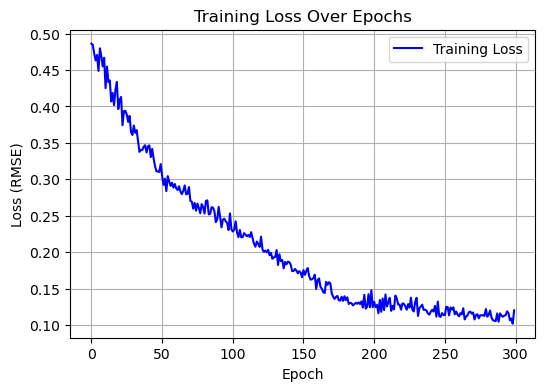

In [36]:
plt.figure(figsize = (6, 4))
plt.plot(epoch_losses.numpy(), label = "Training Loss", color = "b")
plt.xlabel("Epoch")
plt.ylabel("Loss (RMSE)")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

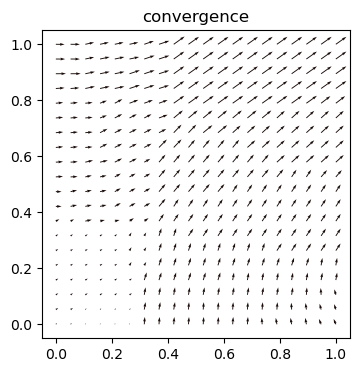

tensor(0.1409, grad_fn=<SqrtBackward0>)

In [38]:
model_v.eval()
pred = vmap(model_v)(x_test)

from metrics import compute_RMSE

visualise_v_quiver(pred.detach(), x_test, title_string = "convergence")

compute_RMSE(pred, simulate_convergence(x_test))

In [39]:
# Functional divergence
torch.diagonal(vmap(jacrev(model_v))(x_train), dim1 = 1, dim2 = 2).sum(0)

tensor([0., 0.], grad_fn=<SumBackward1>)